In [ ]:
"""
This ipynb is used to run bootstrap experiments and plot results, as in the paper
"""

In [372]:
## The goal of this version is to bootstrap all stats

## This version is moving beyond experiment title stuff

import os
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from Effect_Estimate import get_effect_iptw_ATE, get_effect_strat
import pandas as pd 
import os3
import scipy.stats as stats


def plot_by_ax(df, ax, y, print_df = False, ylim = None, save=False):

    if print_df:
        print(df)
        
        
    names = list(set(df['name']))
    plt.figure()
    for name in names:
        df_name = df[df['name'] == name]
        df_name = df_name.sort_values(ax)
        x_name = df_name[ax]
        y_name = df_name[y]

        plt.plot(x_name, y_name, label=name)
    plt.legend()
    
    ax_dict = {'ax0':'Linguistic Complexity', 'ax1':'Presence of Distractors', 'ax2':'Posts are Ordered', 'ax3':'Intensity of Synthetic Posts', 'ax4':'Complexity of Propensity Structure'}
    
    y_dict = {'test_acc':'Accuracy','bias_strat':'Bias in ATE (stratified)','bias_ipw':'Bias in ATE (IPW)','bias_ATE_mean':'Bias in ATE (bootstrap)','brier':'Brier Score','inv_brier':'Inverse Brier Score'}

    y = y_dict[y]
    
    plt.title('{} for {}'.format(y,ax_dict[ax]))
    #plt.title('ax = {}, y = {}'.format(ax,y))
    plt.ylabel(y)
    plt.xlabel(ax_dict[ax])
    
    if ylim is not None:
        plt.ylim(ylim)
    #def plot_axis(ax, y):
    
    plt.savefig(save)

def bootstrap_ATE(P_test, Tt_test, Y_sample, ATE_true, n_it=100):
    runs = []

    for _ in range(n_it):
        bootstrap_inds = np.random.choice(range(len(P_test)), len(P_test))
        runs += [get_effect_iptw_ATE(P_test[bootstrap_inds],
                                     Tt_test[bootstrap_inds],
                                     Y_sample[bootstrap_inds])]
    runs += [ATE_true]
    runs.sort()

    percentile = ((np.where(np.array(runs) == ATE_true)[0][0]).item()/(1.*len(runs)))*100
    
    runs = np.array(runs)
    runs.std()

    return runs.mean(), runs.std(), percentile, runs

In [138]:
# get experimental directories
exp_dirs = [name for name in os.listdir() if ('_60' in name and name[:3] == 'exp' and os.path.isdir(name))] # or ('_40' in name and os.path.isdir(name)) or ('_60' in name and os.path.isdir(name))]
all_exp_dirs = [name for name in os.listdir() if (name[:3] == 'exp' and os.path.isdir(name))] # or ('_40' in name and os.path.isdir(name)) or ('_60' in name and os.path.isdir(name))]

exp_dirs.remove('experiment_0_0_0_1_0_60_backup')

# get experiment features
get_features = lambda d: [int(v) for v in d.split('_')[1:6]]

# get size
get_size = lambda d: d.split('_')[6]

print(exp_dirs)
print(all_exp_dirs)


['experiment_4_0_0_0_0_60', 'experiment_3_0_0_0_0_60', 'experiment_0_0_0_2_0_60', 'experiment_0_0_1_0_0_60', 'experiment_1_0_0_0_0_60', 'experiment_0_0_0_0_0_60', 'experiment_0_0_0_0_1_60', 'experiment_2_0_0_0_0_60', 'experiment_0_1_0_0_0_60', 'experiment_0_0_0_1_0_60']
['experiment_9_min_pw', 'experiment_backups', 'experiment_2_0_0_0_0_20', 'experiment_0_0_0_0_0_30', 'experiment_4_0_0_0_0_60', 'experiment_0_0_0_0_0_xsmall', 'experiment_4_min', 'experiment_3_min', 'experiment_0_1_0_0_0_20', 'experiment_0_0_0_1_0_med', 'experiment_0_1_0_0_0_xsmall', 'experiment_2_xsmall', 'experiment_2', 'experiment_3_0_0_0_0_60', 'experiment_0_0_0_1_0_20', 'experiment_realdata_depression_med', 'experiment_6_min_pw', 'experiment_0_0_0_0_0_40', 'experiment_0_0_0_0_2_xsmall', 'experiment_0_0_0_1_0_60_backup', 'experiment_0_0_0_1_0_xsmall', 'experiment_2_0_0_0_0_xsmall', 'experiment_0_1_0_0_0_30', 'experimentbackups', 'experiment_0_0_0_0_0_20', 'experiment_1_0_0_0_0_90', 'experiment_0_0_0_2_0_60', 'experim

In [1]:
"""
AXIS BLOCK

This block of code defines values for bootstrap experiments as well as plotting
A reduced and labelled example:

axis_0 = {'name': 'Linguistic Complexity',


          'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
          
          
          'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          
          
          'labels': ['constant','+sickness','+isolation', '+death' ],
          
          
          # Next, a list of different experiments
          # each corresponds to a value on this axis
          'experiments':[  
          
              # an experiment is a dictionary
              {
              # first, we have a path to the experiment
              'file_path': 'experiment_0_0_0_0_0_60', 
              # the value on the axis. This is mainly for plotting purposes
               'axis_value': 0,
               
               # Next, the causal structure assigned to the experiment during bootstrapping below
               # Y_sample_classes is a list of length 2, denoting: 
               #       [[P(Y=1|class = 0, T=0),   P(Y=1|class = 0, T=1)], [P(Y=1|class = 1, T=0),   P(Y=1|class = 1, T=1)]]
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               # P_sample_classes is: [p(T|class=0), p(T|class=1)]
               'P_sample_classes': [0.9,0.1],
               
               # These values are calculated by hand for plotting purposes, based on the causal structure above
               # unadjusted is for a model that doesn't have access to confounders
               # optimal is for a model that perfectly models the relationship between confounders and T
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}
              },
              
              
              # we have one list element for each 'experiment' or axis value
              ...
          ]}


"""


axis_0 = {'name': 'Linguistic Complexity',
          'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
          'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          'labels': ['constant','+sick','+isolation', '+death' ],
          
          'experiments':[
              {'file_path': 'experiment_0_0_0_0_0_60',
               'axis_value': 0,#0,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}
              },
              
              {'file_path': 'experiment_1_0_0_0_0_60',
               'axis_value': 1,#1,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
              
              {'file_path': 'experiment_2_0_0_0_0_60',
               'axis_value': 2,#2,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
    
              {'file_path': 'experiment_3_0_0_0_0_60',
               'axis_value': 3,#3,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},

              {'file_path': 'experiment_4_0_0_0_0_60_backup',
               'axis_value': 4,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
              
          ]}

axis_0['experiments'] = axis_0['experiments'][:4]

axis_1 = {'name': 'Signal Intensity',
          'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
          'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          'labels': ['large','small'],
          'experiments':[
              

              
              {'file_path': 'experiment_0_0_0_2_0_60',
               'axis_value': 0,#10,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
                
              {'file_path': 'experiment_0_0_0_1_0_60',
               'axis_value': 1,#3,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
          ]}

axis_2 = {'name': 'Order of Text',
          'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
          'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          'labels': ['irrelevant','relevant' ],
          'experiments':[
              {'file_path': 'experiment_1_0_0_0_0_60',
               'axis_value': 0,#0,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}},
              
              {'file_path': 'experiment_0_0_1_0_0_60',
               'axis_value': 1,#1,
               'P_sample_classes': [0.9,0.1],
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1.}}
          ]}

axis_3 = {'name': 'Strength of Selection Effect',
          'unadjusted':{'test_acc':(0.5,0.525), 'bias_strat':(-0.32,-0.357), 'bias_ipw':(-0.32,-0.357),'spearman':0.},
          'optimal':{'test_acc':(0.9, 0.925), 'bias_strat':(0.,0.), 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          'labels': ['0.9','0.95'],
          'experiments':[
              {'file_path': 'experiment_1_0_0_0_0_60',
               'axis_value': 0,#0,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
              'P_sample_classes': [0.9,0.1]},
              
              {'file_path': 'experiment_0_0_0_0_1_60',
               'axis_value': 1,#1,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.95,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.27, 'bias_ipw':-0.27,'spearman':0.},
              'optimal':{'test_acc':0.925, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.}}
          ]}

axis_4 = {'name': 'Number of Users',
          'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
          'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
          'labels': ['8000','4000', '2000'],
          'experiments':[
              {'file_path': 'experiment_1_0_0_0_0_60',
               'axis_value': 0,#8000,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
               'P_sample_classes': [0.9,0.1],
              'unadjusted':{'test_acc':0.5, 'bias_strat':-0.32, 'bias_ipw':-0.32,'spearman':0.},
              'optimal':{'test_acc':0.9, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.}},
              
              {'file_path': 'experiment_1_0_0_0_0_60_nuser4000',
               'axis_value': 1,#4000,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
              'P_sample_classes': [0.9,0.1]},
              {'file_path': 'experiment_1_0_0_0_0_60_nuser2000',
               'axis_value': 2,#2000,
               'Y_sample_classes': [[0.9,0.1],[0.9,0.9]],
              'P_sample_classes': [0.9,0.1]}
          ]}


axis_5 =  {'name': 'Absence of Treatment Effect',
           'unadjusted':{'test_acc':0.525, 'bias_strat':-0.034, 'bias_ipw':-0.034,'spearman':0.},
           'optimal':{'test_acc':0.925, 'bias_strat':0., 'bias_ipw':0.,'spearman':1., 'mse_ipsw':0.},
           'labels': ['' ],
          'experiments':[
              {'file_path': 'experiment_0_0_0_0_1_60',
               'axis_value': 0,
               'Y_sample_classes': [[0.95,0.05],[0.05,0.95]],
              'P_sample_classes': [0.95,0.1]},

          ]}



list_of_axes = [axis_0, axis_1, axis_2, axis_3, axis_4, axis_5]



#######
starting: Linguistic Complexity
######## 
running {'file_path': 'experiment_0_0_0_0_0_60', 'axis_value': 0, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.1, 0.1, 0.1, ..., 0.9, 0.1, 0.1], dtype=object), 'results_dict': {'Logistic_Regression_counts': {'name': 'Logistic_Regression_counts', 'test_acc': [0.88625, 0.89225, 0.8975, 0.8865, 0.88675, 0.889, 0.89175, 0.88525, 0.88275, 0.88825, 0.8935, 0.89175, 0.879, 0.89, 0.896, 0.8865, 0.89425, 0.8885, 0.89125, 0.8845, 0.89925, 0.88625, 0.894, 0.9, 0.89, 0.88475, 0.8855, 0.88475, 0.893, 0.89475, 0.887, 0.89025, 0.88775, 0.897, 0.89825, 0.88675, 0.89475, 0.899, 0.884, 0.88725, 0.89075, 0.8855, 0.887, 0.89325, 0.895, 0.8935, 0.88875, 0.88575, 0.88525, 0.896, 0.8915, 0.8925, 0.88725, 0.88225, 0.89675, 0.8905, 0.882

true ATE: 0.4
ATE oracle bootstrap: (0.41032368402883584, 0.021781473192139, 29.47052947052947, array([0.32975783, 0.34166632, 0.34435856, ..., 0.46876478, 0.47008552,
       0.47168376]))
bias of mean: 0.010323684028835822



doing model Logistic_Regression_counts
doing model oracle
doing model Logistic_Regression
doing model Simple_NN_(1gram)
doing model Simple_NN
doing model Simple_NN_counts
doing model Simple_NN_LDA
doing model HBERT
doing model Logistic_Regression_LDA
doing model Logistic_Regression_(1gram)
doing model avgBERT
running {'file_path': 'experiment_1_0_0_0_0_60', 'axis_value': 1, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.9, 0.1, 0.9, ..., 0.1, 0.1, 0.9], dtype=object), 'results_dict': {'Logistic_Regression_counts': {'name': 'Logistic_Regression

true ATE: 0.4
ATE oracle bootstrap: (0.41248516223978776, 0.02168976315352494, 28.471528471528472, array([0.34084825, 0.3509718 , 0.35241851, ..., 0.46900355, 0.47776046,
       0.49370563]))
bias of mean: 0.01248516223978774



doing model Logistic_Regression_counts
doing model oracle
doing model Logistic_Regression_(1gram)
doing model Simple_NN
doing model Simple_NN_(1gram)
doing model Simple_NN_counts
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression
doing model HBERT


/homes/gws/pawest/miniconda3/envs/torch4/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


running {'file_path': 'experiment_2_0_0_0_0_60', 'axis_value': 2, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.9, 0.9, 0.1, ..., 0.1, 0.9, 0.1], dtype=object), 'results_dict': {'avgBERT': {'name': 'avgBERT', 'test_acc': [0.505, 0.495, 0.508, 0.50675, 0.503, 0.49375, 0.49125, 0.4925, 0.50375, 0.49, 0.505, 0.5065, 0.48925, 0.50425, 0.49, 0.514, 0.5175, 0.50825, 0.501, 0.50775, 0.48875, 0.51675, 0.49675, 0.50525, 0.50425, 0.50425, 0.5035, 0.51, 0.50525, 0.4995, 0.508, 0.4855, 0.51725, 0.51275, 0.49325, 0.51, 0.50975, 0.49, 0.50275, 0.5115, 0.495, 0.503, 0.50825, 0.4945, 0.50925, 0.511, 0.50025, 0.5005, 0.49675, 0.504, 0.5175, 0.507, 0.49225, 0.51325, 0.50675, 0.5125, 0.508, 0.49825, 0.494, 0.511, 0.51125, 0.511, 0.49925, 0.514, 0.5085, 0.5095, 0.51425, 0.5235, 0.5012

true ATE: 0.4
ATE oracle bootstrap: (0.3342733945865766, 0.02341337386305023, 99.7002997002997, array([0.26283212, 0.26398378, 0.26558512, ..., 0.4       , 0.40374385,
       0.40804272]))
bias of mean: 0.0657266054134234



doing model avgBERT
doing model Simple_NN_(1gram)
doing model Logistic_Regression_LDA
doing model Simple_NN_LDA
doing model HBERT
doing model oracle
doing model Simple_NN
doing model Logistic_Regression
doing model Logistic_Regression_counts
doing model Logistic_Regression_(1gram)
doing model Simple_NN_counts
running {'file_path': 'experiment_3_0_0_0_0_60', 'axis_value': 3, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.9, 0.1, 0.1, ..., 0.9, 0.1, 0.9], dtype=object), 'results_dict': {'Logistic_Regression': {'name': 'Logistic_Regression', 'test_

true ATE: 0.4
ATE oracle bootstrap: (0.3605507714856654, 0.022369702736054833, 96.90309690309691, array([0.2978331 , 0.29956785, 0.29995707, ..., 0.42746159, 0.43216711,
       0.4405277 ]))
bias of mean: 0.03944922851433463



doing model Logistic_Regression
doing model Logistic_Regression_LDA
doing model Simple_NN_(1gram)
doing model HBERT
doing model Logistic_Regression_counts
doing model Simple_NN_counts
doing model avgBERT
doing model Logistic_Regression_(1gram)
doing model Simple_NN_LDA
doing model oracle
doing model Simple_NN


#######
starting: Signal Intensity
######## 
running {'file_path': 'experiment_0_0_0_2_0_60', 'axis_value': 0, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.1, 0.9, 0.9, ..., 0.9, 0.1, 0.9], dtype=object), 'results_dict': {'Simple_NN_

true ATE: 0.4
ATE oracle bootstrap: (0.44445796716256614, 0.020845920578712856, 1.5984015984015985, array([0.37515377, 0.37630155, 0.37811321, ..., 0.49881806, 0.5016284 ,
       0.50604088]))
bias of mean: 0.044457967162566114



doing model Simple_NN_counts
doing model Logistic_Regression
doing model Logistic_Regression_counts
doing model Simple_NN_LDA
doing model Simple_NN_(1gram)
doing model Simple_NN
doing model Logistic_Regression_LDA
doing model HBERT
doing model Logistic_Regression_(1gram)
doing model oracle
running {'file_path': 'experiment_0_0_0_1_0_60', 'axis_value': 1, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.1, 0.9, 0.9, ..., 0.9, 0.1, 0.1], dtype=object), 'results_dict': {'Simple_NN': {'name': 'Simple_NN', 'test_acc': [0.7925, 0.79125, 0.7935, 0.

true ATE: 0.4
ATE oracle bootstrap: (0.4286771881946725, 0.020847093790007036, 8.89110889110889, array([0.35628864, 0.36377492, 0.36444152, ..., 0.48154802, 0.48214469,
       0.48244057]))
bias of mean: 0.028677188194672465



doing model Simple_NN
doing model Logistic_Regression
doing model Simple_NN_counts
doing model Logistic_Regression_LDA
doing model oracle
doing model Logistic_Regression_(1gram)
doing model Simple_NN_LDA
doing model Simple_NN_(1gram)
doing model HBERT
doing model Logistic_Regression_counts


#######
starting: Order of Text
######## 
running {'file_path': 'experiment_1_0_0_0_0_60', 'axis_value': 0, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.9, 0.1, 0.9, ..., 0.1, 0.1, 0.9], dtype=object), 'results_dict': {'Logistic_Regression_counts': {'na

true ATE: 0.4
ATE oracle bootstrap: (0.3932416448700102, 0.022284920212968348, 60.93906093906094, array([0.32579033, 0.32624913, 0.33053934, ..., 0.45738124, 0.46021259,
       0.46710106]))
bias of mean: 0.006758355129989846



doing model Logistic_Regression_counts
doing model oracle
doing model Logistic_Regression_(1gram)
doing model Simple_NN
doing model Simple_NN_(1gram)
doing model Simple_NN_counts
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression
doing model HBERT
running {'file_path': 'experiment_0_0_1_0_0_60', 'axis_value': 1, 'P_sample_classes': [0.9, 0.1], 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0}, 'Pt_test': array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1], dtype=object), 'results_dict': {'Logistic_Regression_counts': {'name': 'Logistic_Regression_counts', 'test_ac

true ATE: 0.4
ATE oracle bootstrap: (0.3945571411724278, 0.021717446338434275, 59.240759240759246, array([0.28275666, 0.32856756, 0.33155466, ..., 0.44897752, 0.45500976,
       0.46188208]))
bias of mean: 0.005442858827572228



doing model Logistic_Regression_counts
doing model Simple_NN_counts
doing model Logistic_Regression
doing model Logistic_Regression_(1gram)
doing model HBERT
doing model Simple_NN_LDA
doing model Simple_NN
doing model oracle
doing model Logistic_Regression_LDA
doing model Simple_NN_(1gram)


#######
starting: Strength of Selection Effect
######## 
running {'file_path': 'experiment_1_0_0_0_0_60', 'axis_value': 0, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'Pt_test': array([0.9, 0.1, 0.9, ..., 0.1, 0.1, 0.9], dtype=object), 'results_dict': {'Logistic_Regression_counts': {'name': 'Logistic_Regression_counts', 'test_acc': [0.83175, 0.819, 0.83975, 0.838, 0.82575, 0.8345, 0.84475, 0.82, 0.83175, 0.82875, 0.83, 0.8355, 0.82625, 0.8

true ATE: 0.4
ATE oracle bootstrap: (0.39969914481300745, 0.022092018842096002, 48.75124875124875, array([0.33007116, 0.33545579, 0.33686655, ..., 0.4586834 , 0.46337126,
       0.46815361]))
bias of mean: 0.00030085518699257685



doing model Logistic_Regression_counts
doing model oracle
doing model Logistic_Regression_(1gram)
doing model Simple_NN
doing model Simple_NN_(1gram)
doing model Simple_NN_counts
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression
doing model HBERT
running {'file_path': 'experiment_0_0_0_0_1_60', 'axis_value': 1, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.95, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.27, 'bias_ipw': -0.27, 'spearman': 0.0}, 'optimal': {'test_acc': 0.925, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0, 'mse_ipsw': 0.0}, 'Pt_test': array([0.1, 0.95, 0.95, ..., 0.95, 0.1, 0.95], dtype=object), 'results_dict': {'Simple_NN': {'name': 'Simple_NN', 'test_acc': [0.

true ATE: 0.4
ATE oracle bootstrap: (0.3511489694255447, 0.02951795525297274, 95.5044955044955, array([0.24770332, 0.25223904, 0.26306174, ..., 0.42946796, 0.43021708,
       0.43060866]))
bias of mean: 0.048851030574455334



doing model Simple_NN
doing model avgBERT
doing model oracle
doing model Logistic_Regression
doing model HBERT
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression_counts
doing model Simple_NN_counts
doing model Logistic_Regression_(1gram)
doing model Simple_NN_(1gram)


#######
starting: Number of Users
######## 
running {'file_path': 'experiment_1_0_0_0_0_60', 'axis_value': 0, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'unadjusted': {'test_acc': 0.5, 'bias_strat': -0.32, 'bias_ipw': -0.32, 'spearman': 0.0}, 'optimal': {'test_acc': 0.9, 'bias_strat': 0.0, 'bias_ipw': 0.0, 'spearman': 1.0, 'mse_ipsw': 0.0}, 'Pt_test': array([0.9, 0.1, 0.9, ..., 0.1, 0.1, 0.9], dtype=object), 'results_dict

true ATE: 0.4
ATE oracle bootstrap: (0.42643785168829085, 0.020559413821706205, 9.090909090909092, array([0.35478401, 0.35769664, 0.36458035, ..., 0.48742675, 0.48810313,
       0.49647543]))
bias of mean: 0.026437851688290825



doing model Logistic_Regression_counts
doing model oracle
doing model Logistic_Regression_(1gram)
doing model Simple_NN
doing model Simple_NN_(1gram)
doing model Simple_NN_counts
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression
doing model HBERT
running {'file_path': 'experiment_1_0_0_0_0_60_nuser4000', 'axis_value': 1, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'Pt_test': array([0.9, 0.1, 0.9, ..., 0.1, 0.9, 0.1], dtype=object), 'results_dict': {'HBERT': {'name': 'HBERT', 'test_acc': [0.6915, 0.6875, 0.692, 0.6905, 0.683, 0.7105, 0.711, 0.6895, 0.687, 0.6915, 0.706, 0.698, 0.6865, 0.7025, 0.704, 0.7025, 0.67, 0.693, 0.6925, 0.715, 0.683, 0.688, 0.6895, 0.6985, 0.688, 0.6855, 0.690

true ATE: 0.4
ATE oracle bootstrap: (0.4214522079047381, 0.030938884972583756, 23.276723276723278, array([0.29283281, 0.31705597, 0.3204529 , ..., 0.50381869, 0.50662708,
       0.51002237]))
bias of mean: 0.021452207904738063



doing model HBERT
doing model Simple_NN
doing model Simple_NN_LDA
doing model Simple_NN_(1gram)
doing model Logistic_Regression_(1gram)
doing model Logistic_Regression
doing model Logistic_Regression_counts
doing model Logistic_Regression_LDA
doing model oracle
doing model Simple_NN_counts
running {'file_path': 'experiment_1_0_0_0_0_60_nuser2000', 'axis_value': 2, 'Y_sample_classes': [[0.9, 0.1], [0.9, 0.9]], 'P_sample_classes': [0.9, 0.1], 'Pt_test': array([0.1, 0.9, 0.9, 0.1, 0.1, 0.9, 0.1, 0.1, 0.9, 0.9, 0.9, 0.1, 0.9,
       0.1, 0.9, 0.9, 0.9, 0.1, 0.9, 0.1, 0.9, 0.9, 0.1, 0.9, 0.1, 0.1,
       0.1, 0.1, 0.9, 0.1, 0.1, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.1,
       0.9, 0.1, 0.9, 0.9, 0.9, 0.1, 0.1, 0.9, 0.1, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.1, 0.9, 0.1,

true ATE: 0.4
ATE oracle bootstrap: (0.41487327651101763, 0.045954658840473096, 35.66433566433567, array([0.25672778, 0.27060084, 0.27652311, ..., 0.53007128, 0.53029729,
       0.54163273]))
bias of mean: 0.014873276511017608



doing model Simple_NN_(1gram)
doing model Logistic_Regression_LDA
doing model Simple_NN_LDA
doing model Logistic_Regression
doing model Logistic_Regression_counts
doing model HBERT
doing model Simple_NN
doing model Simple_NN_counts
doing model Logistic_Regression_(1gram)
doing model oracle


#######
starting: Absence of Treatment Effect
######## 
running {'file_path': 'experiment_0_0_0_0_1_60', 'axis_value': 0, 'Y_sample_classes': [[0.95, 0.05], [0.05, 0.95]], 'P_sample_classes': [0.95, 0.1], 'Pt_test': array([0.1, 0.95, 0.95, ..., 0.95, 0.1, 0.95], dtype=object), 'results_dict': {'Simple_NN': {'name': 'Simple_NN', 'test_acc': [0.85125, 0.8555, 0.85125, 0.857, 0.8545, 0.85425, 0.857, 0.84875, 0.8515, 0.84975, 0.85025, 0.84775, 0.85125, 0.857, 0.84925, 0.85175,

true ATE: 0.0
ATE oracle bootstrap: (-0.028369144169763324, 0.0313146959296496, 81.81818181818183, array([-0.14089768, -0.12042723, -0.11807891, ...,  0.05669047,
        0.0580783 ,  0.07491679]))
bias of mean: 0.028369144169763324



doing model Simple_NN
doing model avgBERT
doing model oracle
doing model Logistic_Regression
doing model HBERT
doing model Simple_NN_LDA
doing model Logistic_Regression_LDA
doing model Logistic_Regression_counts
doing model Simple_NN_counts
doing model Logistic_Regression_(1gram)
doing model Simple_NN_(1gram)


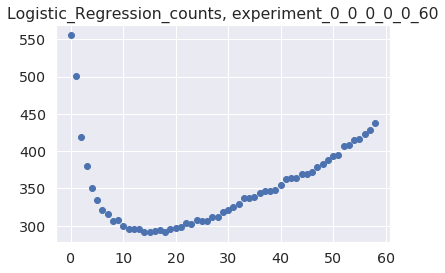

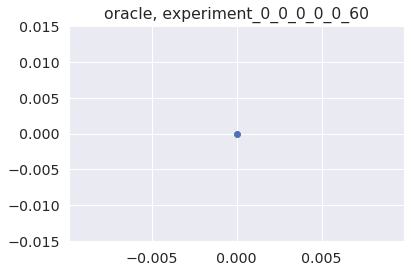

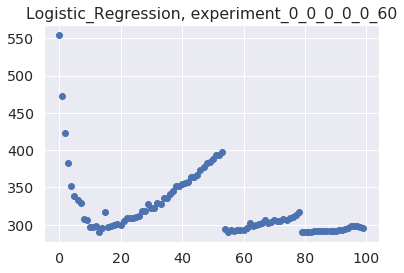

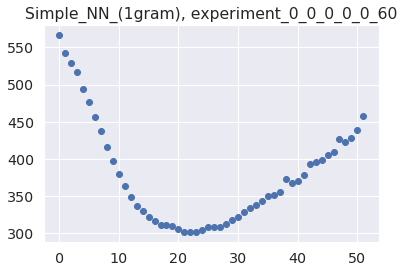

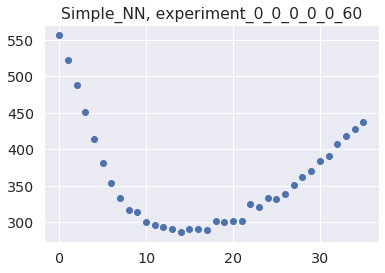

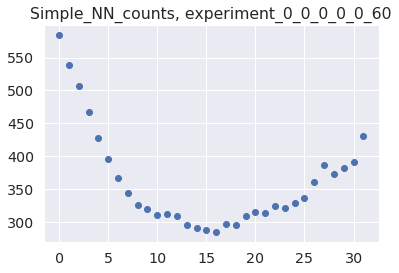

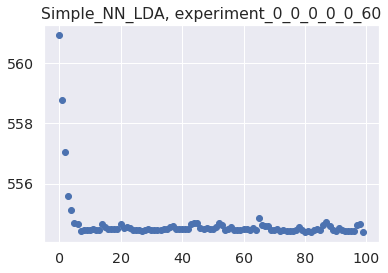

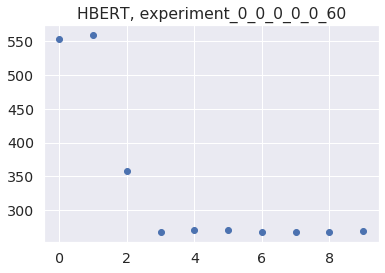

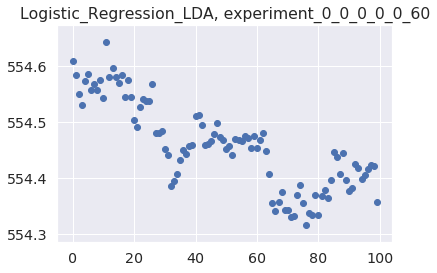

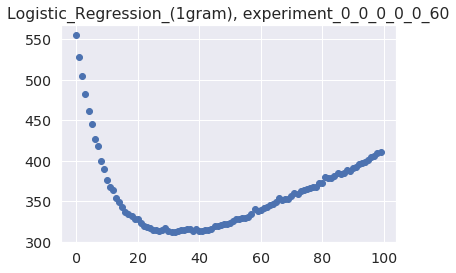

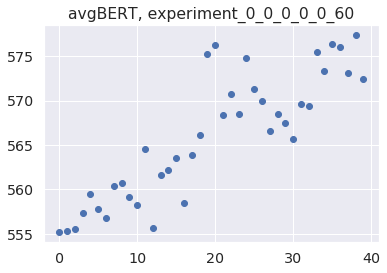

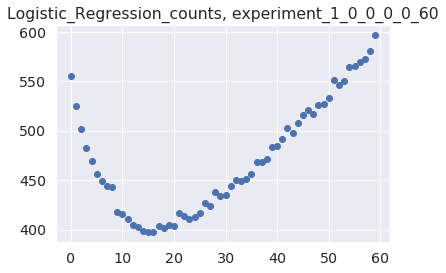

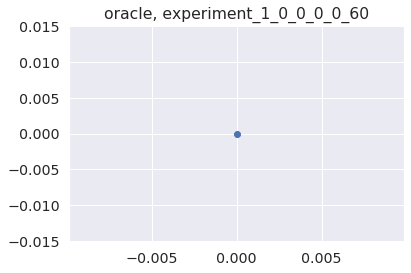

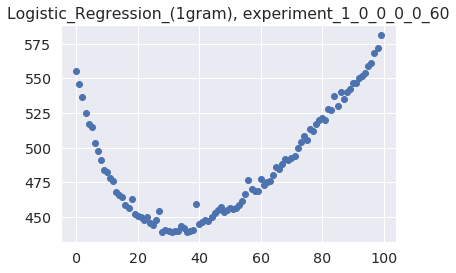

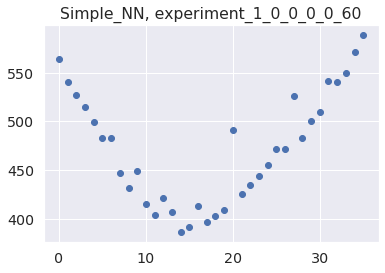

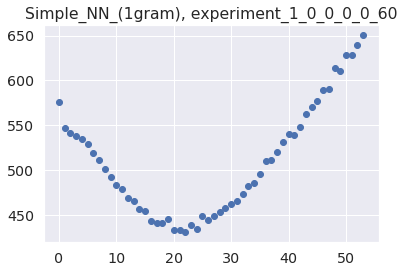

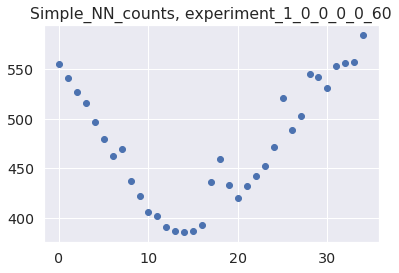

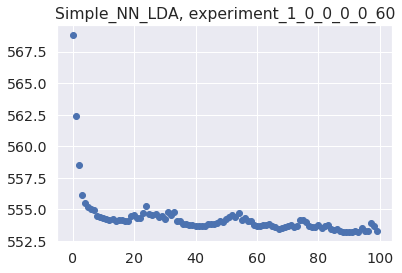

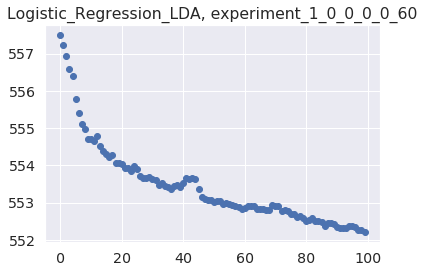

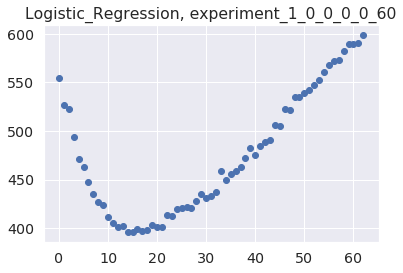

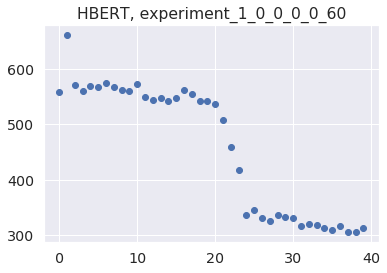

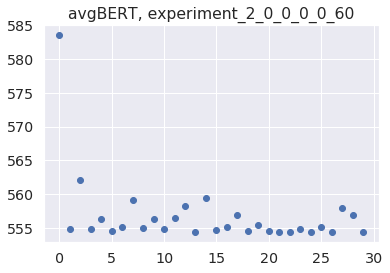

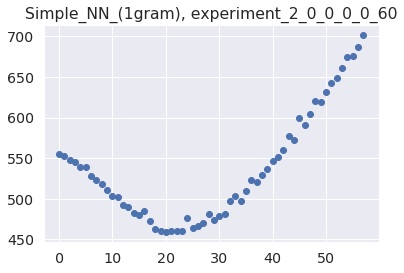

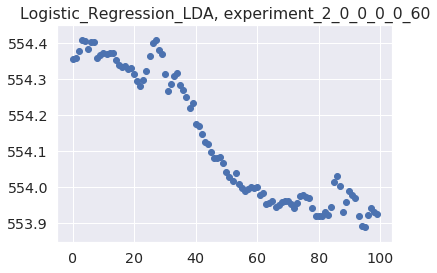

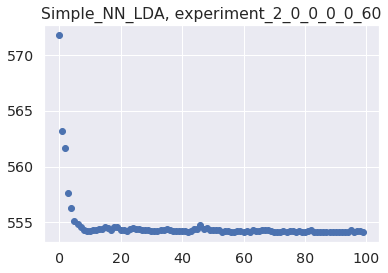

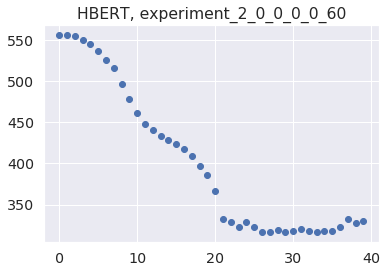

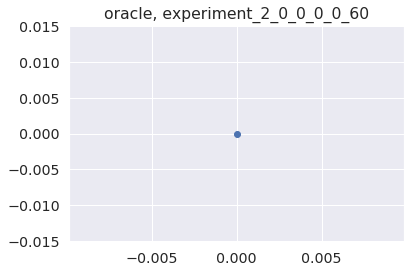

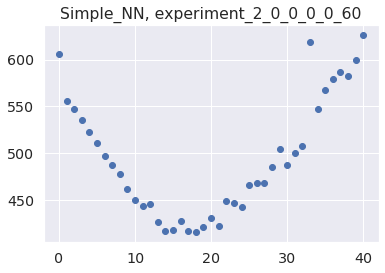

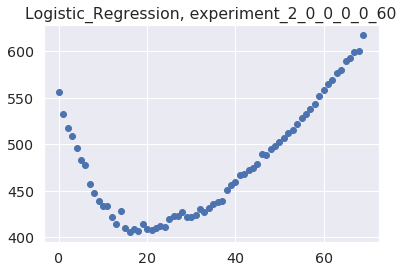

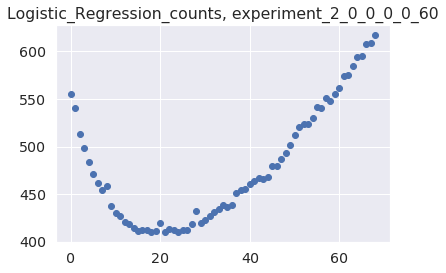

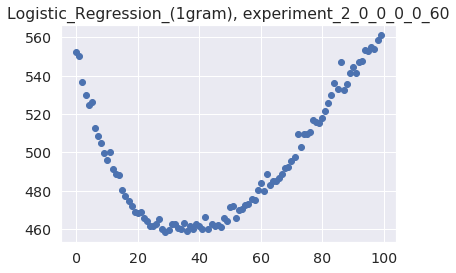

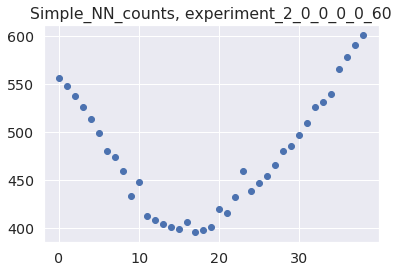

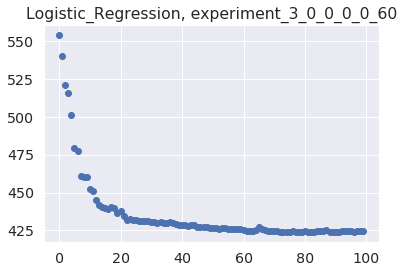

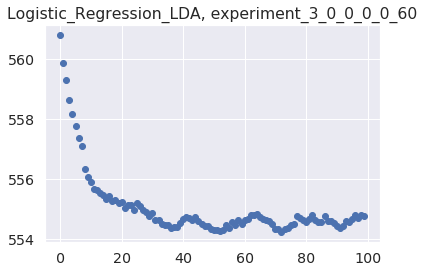

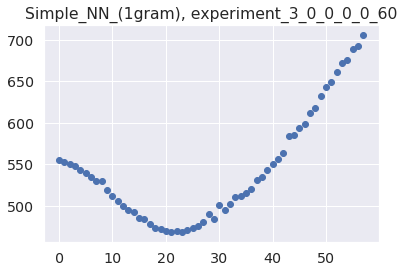

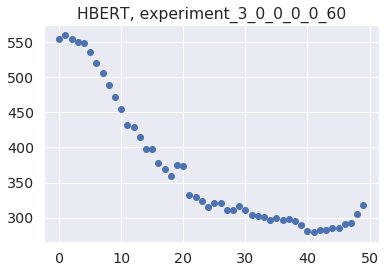

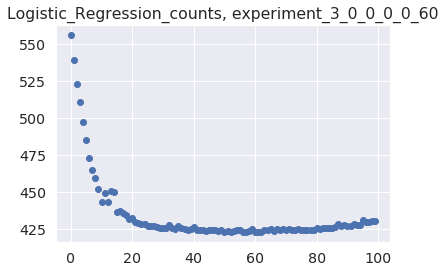

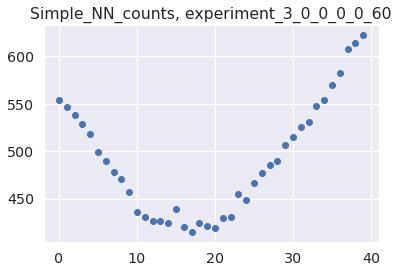

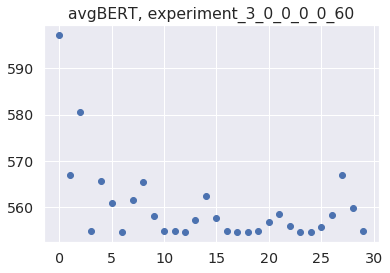

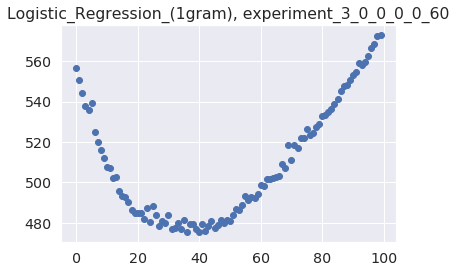

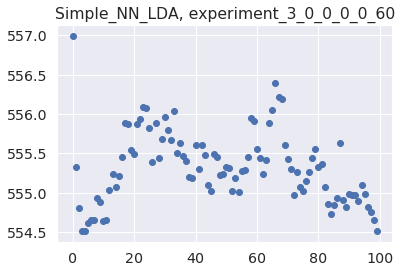

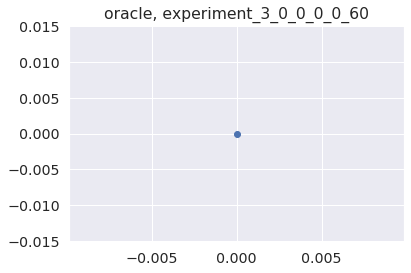

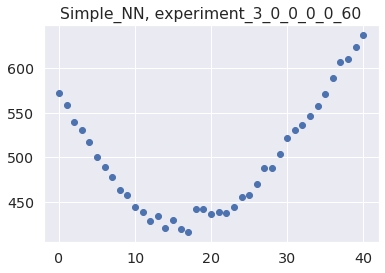

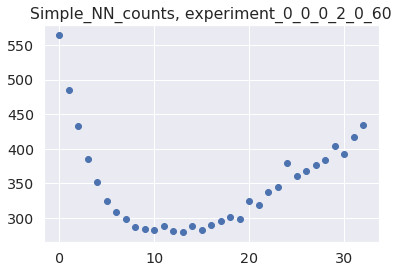

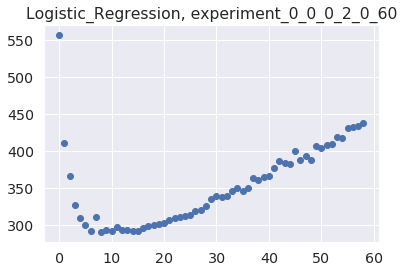

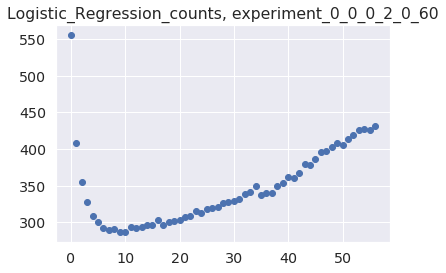

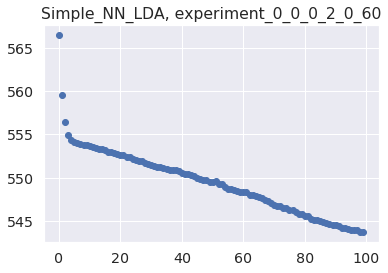

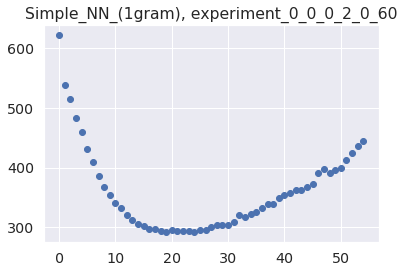

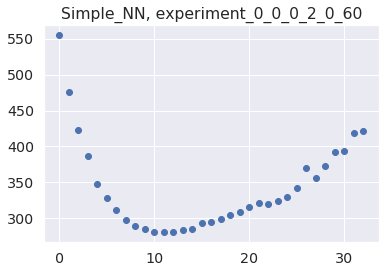

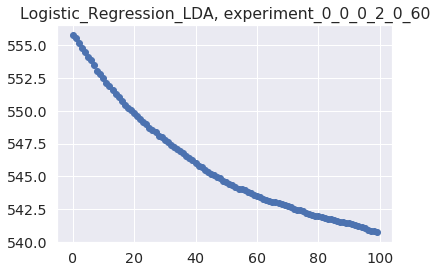

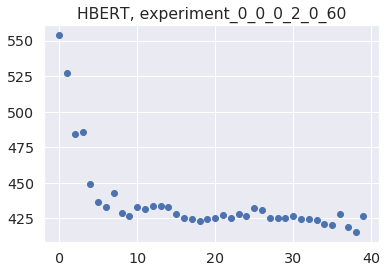

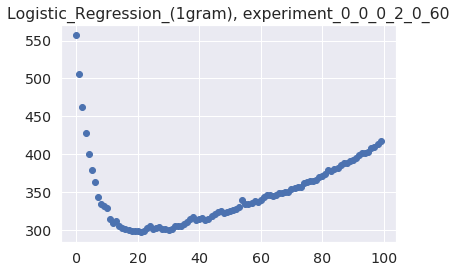

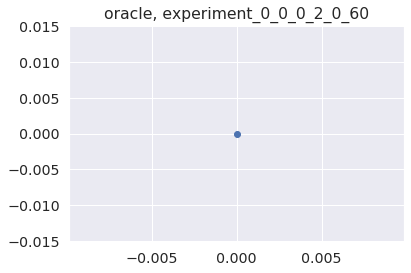

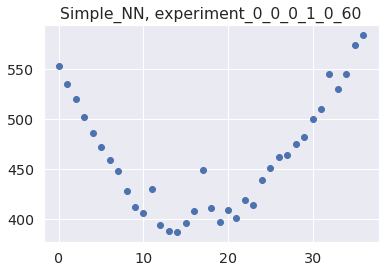

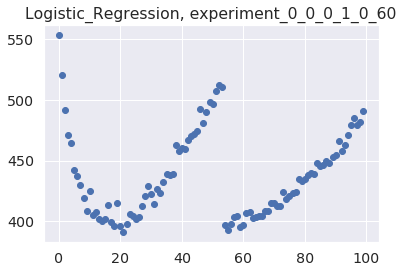

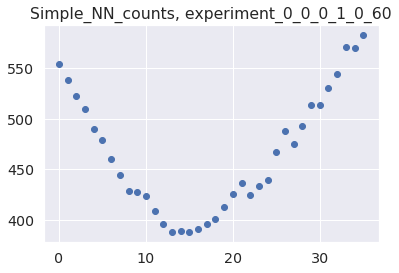

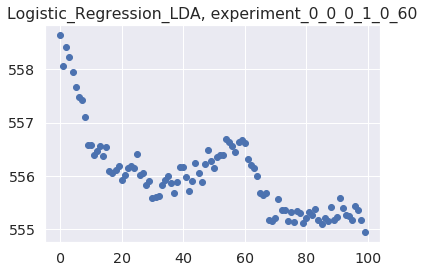

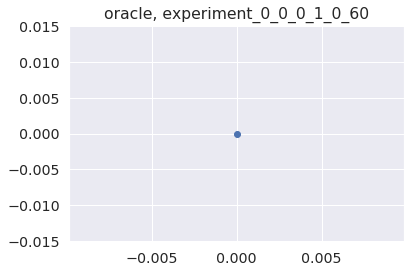

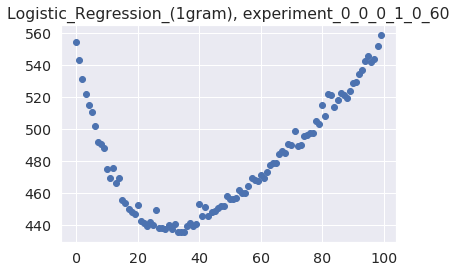

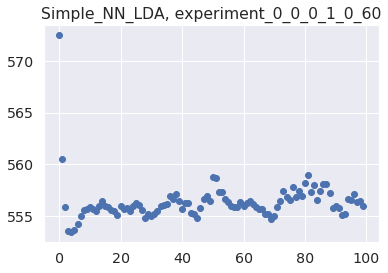

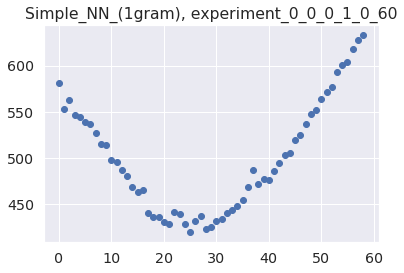

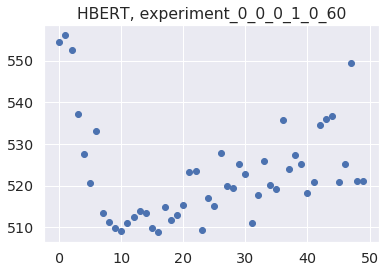

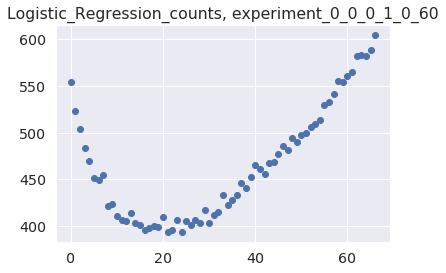

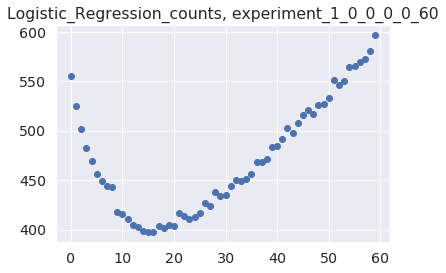

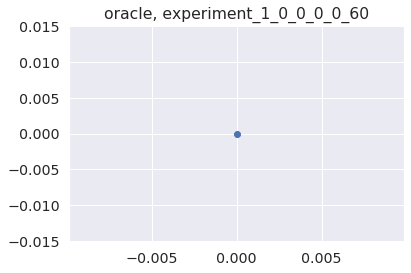

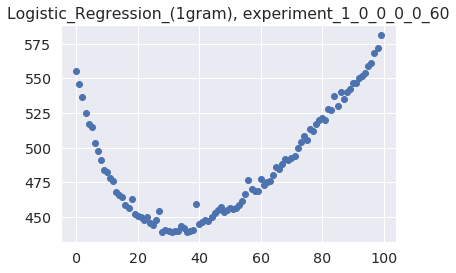

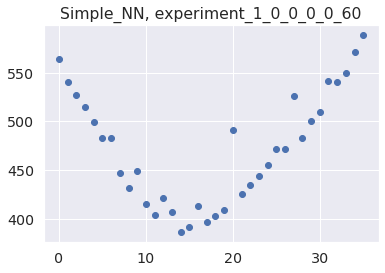

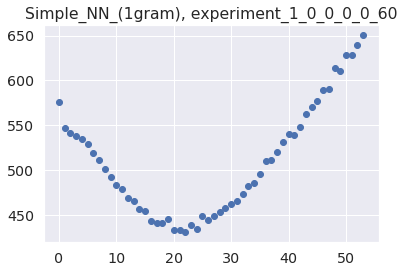

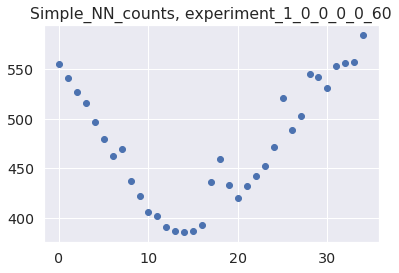

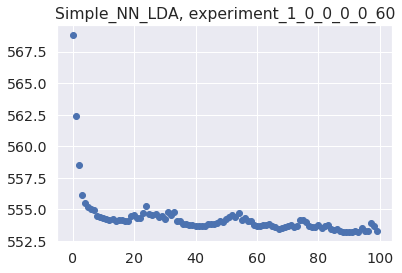

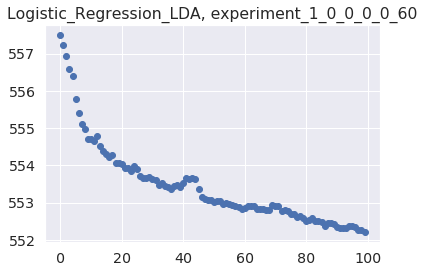

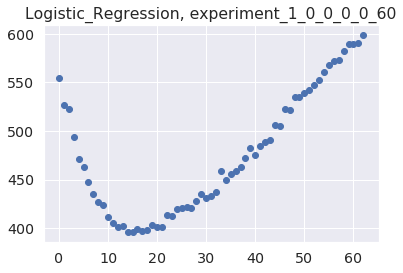

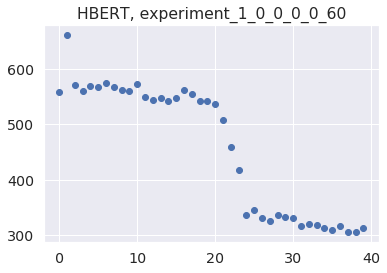

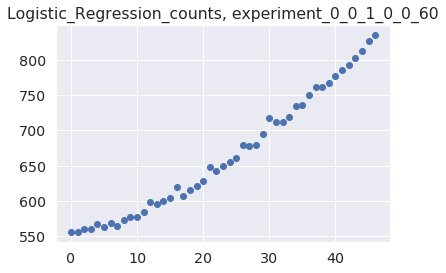

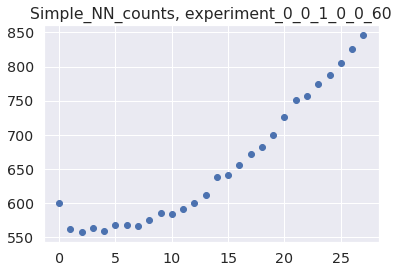

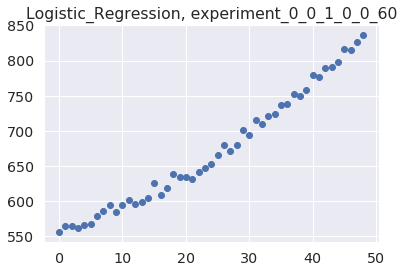

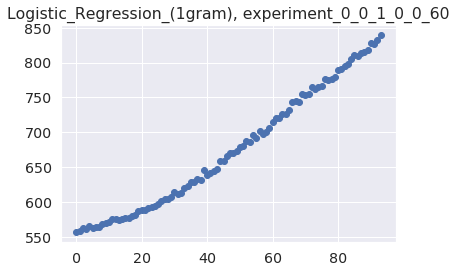

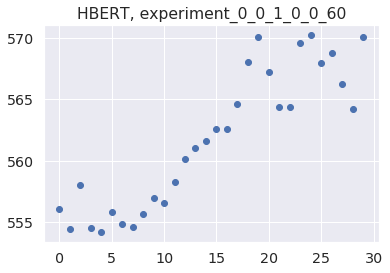

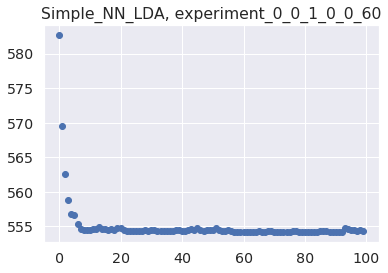

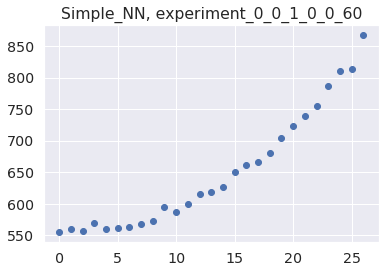

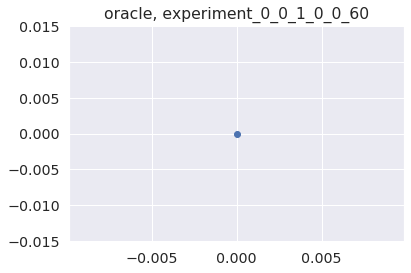

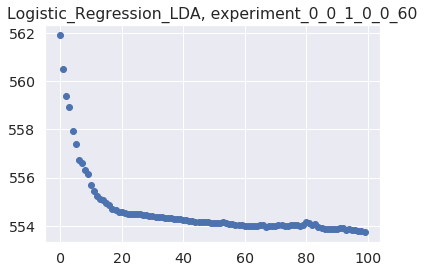

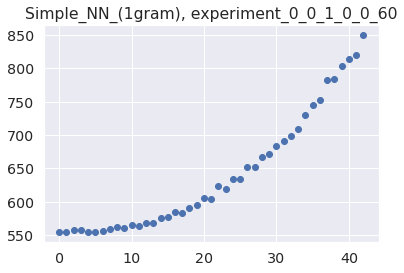

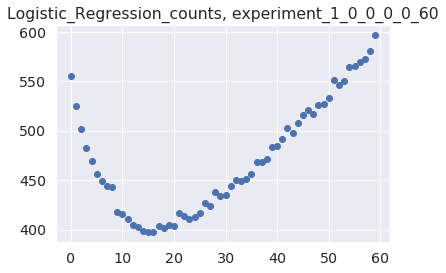

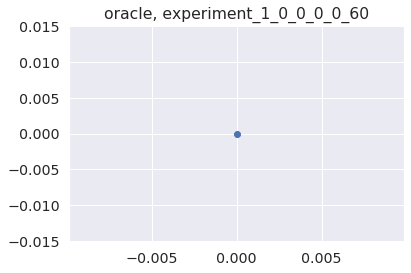

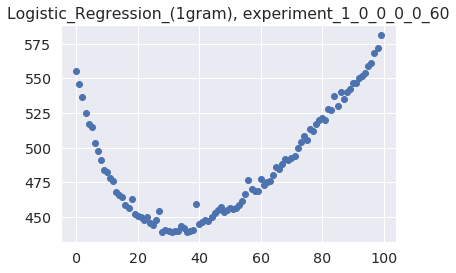

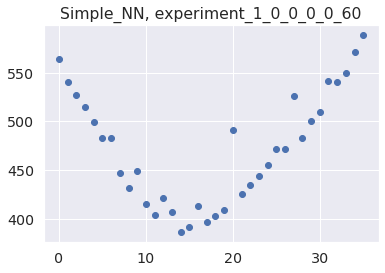

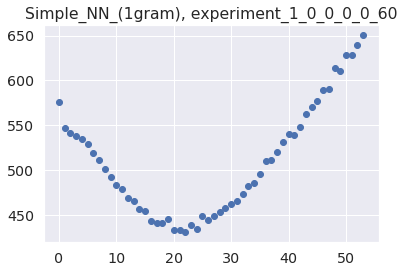

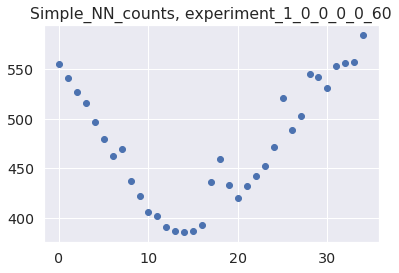

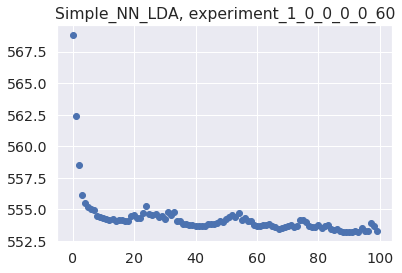

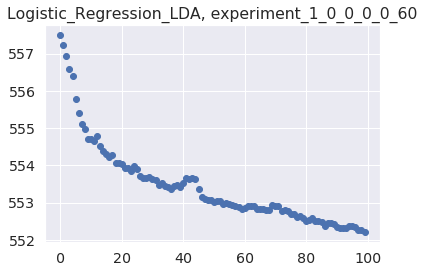

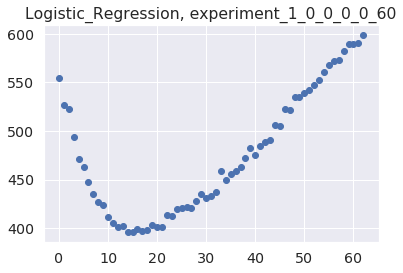

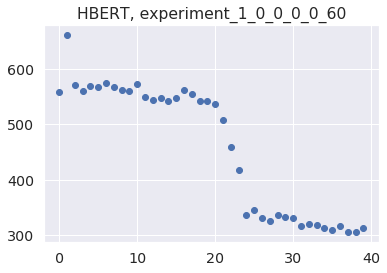

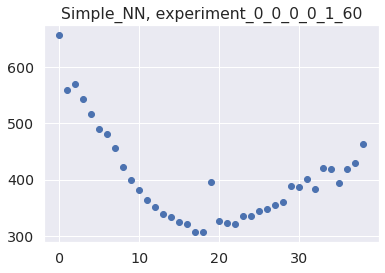

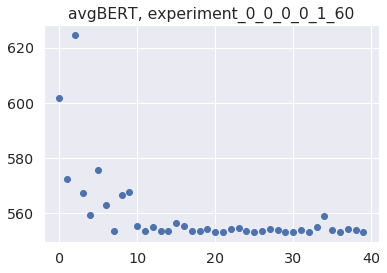

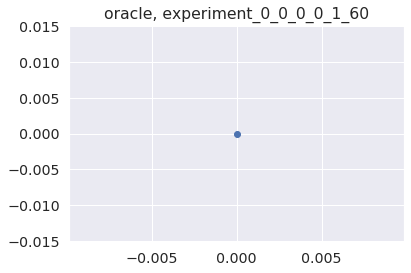

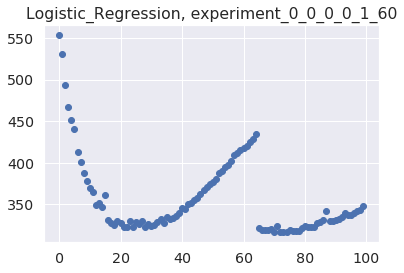

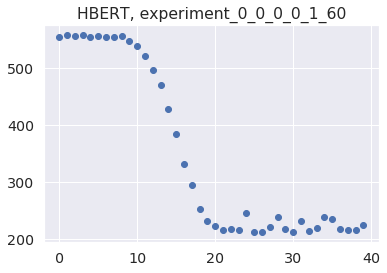

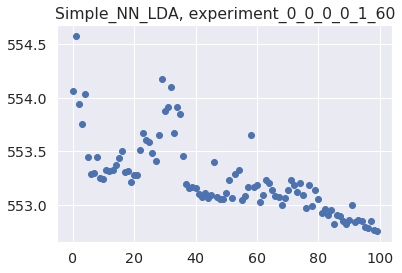

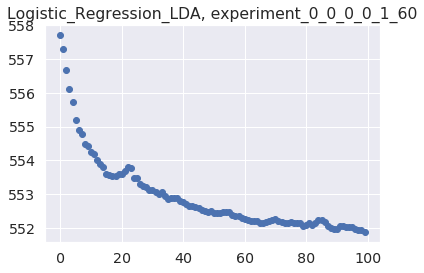

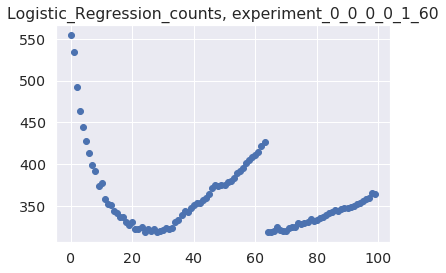

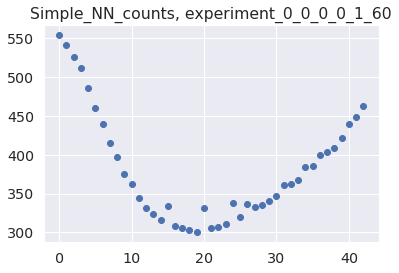

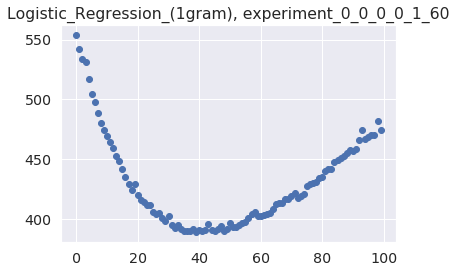

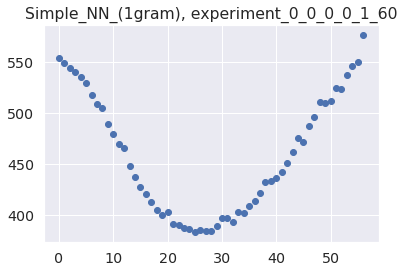

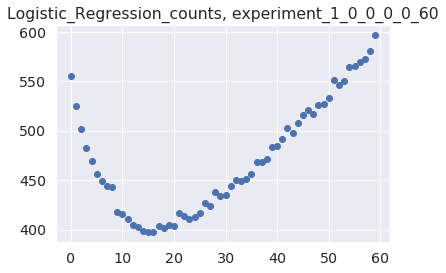

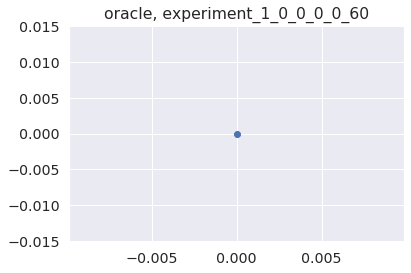

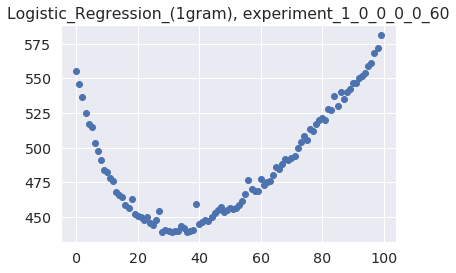

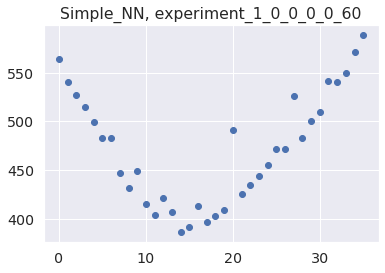

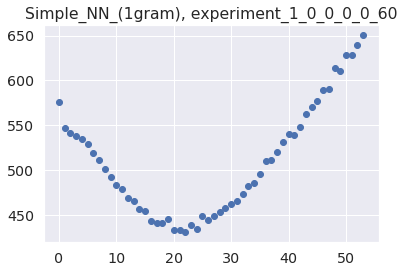

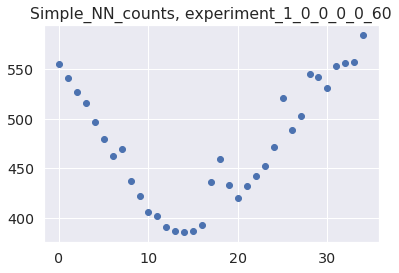

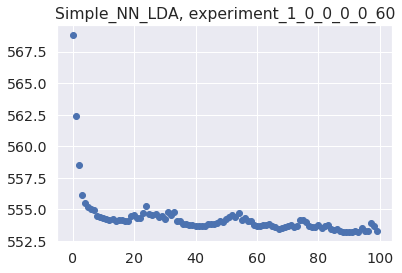

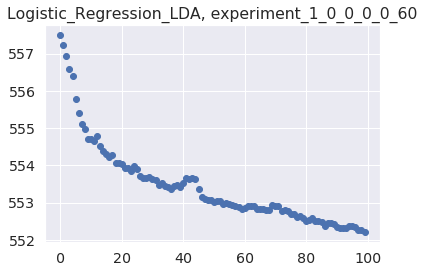

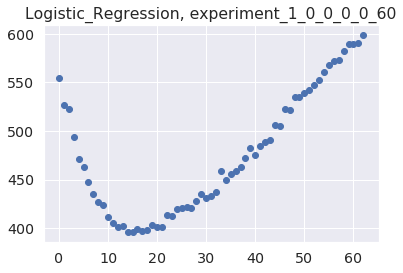

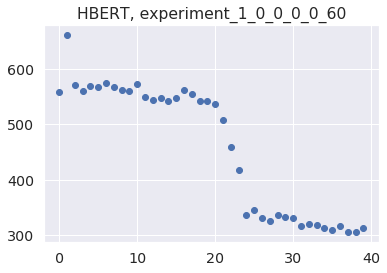

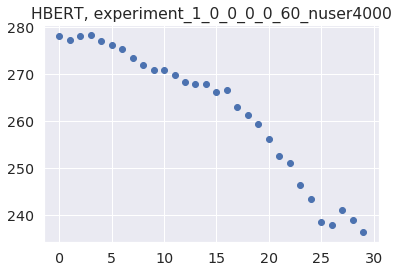

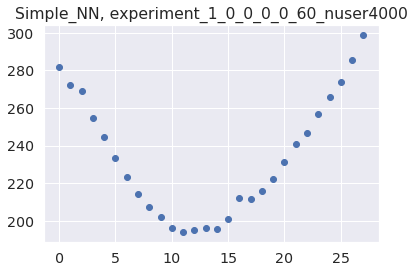

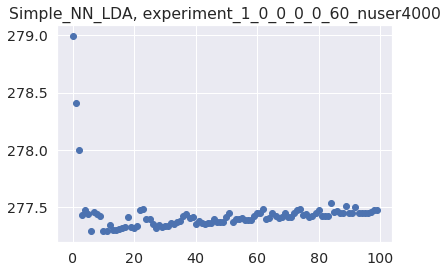

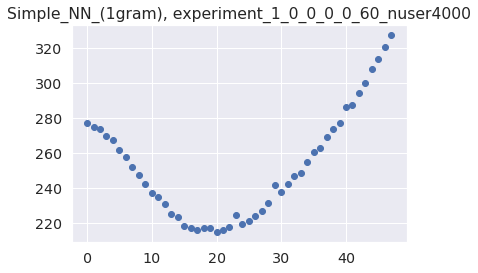

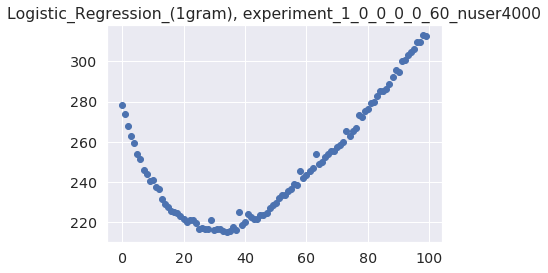

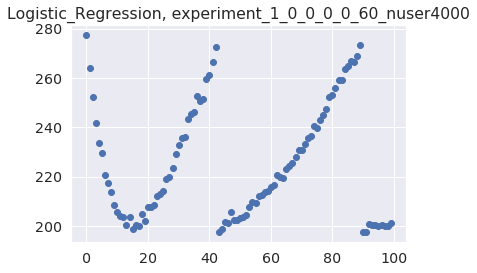

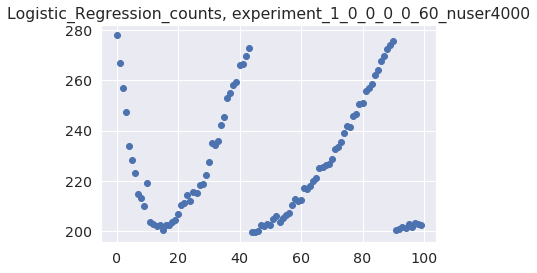

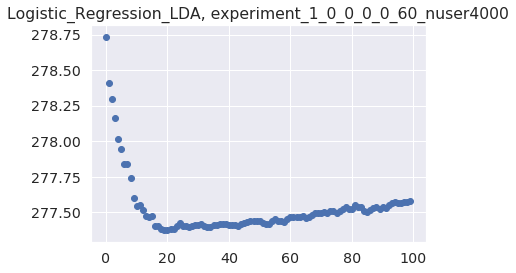

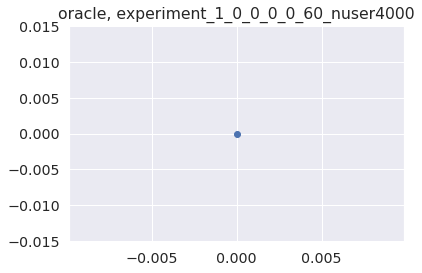

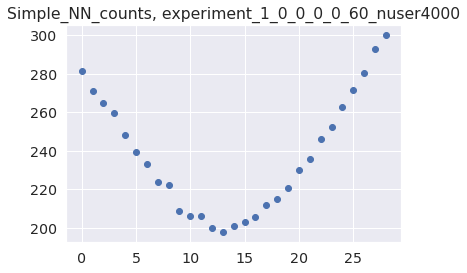

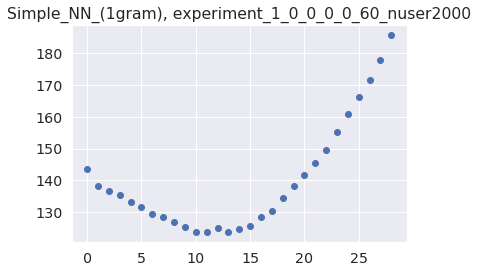

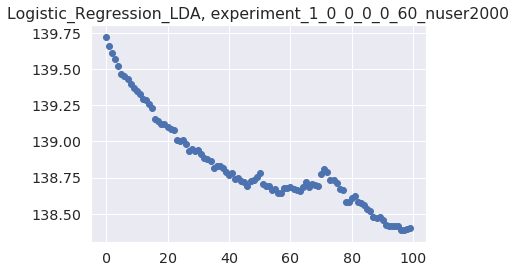

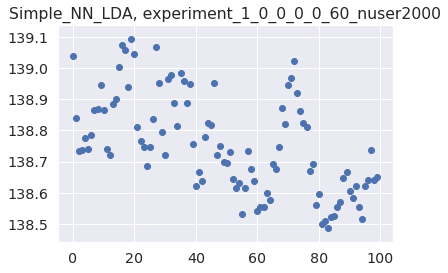

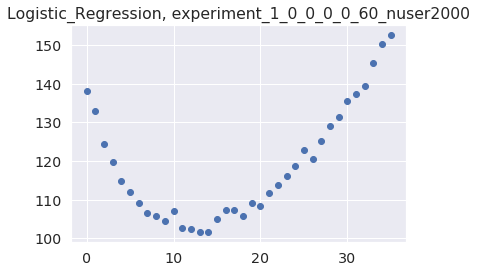

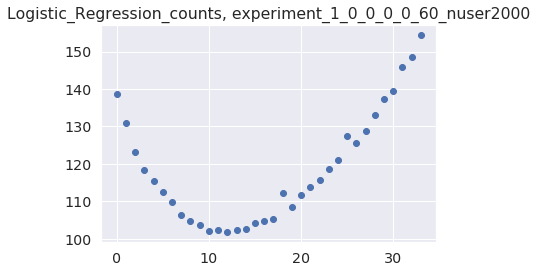

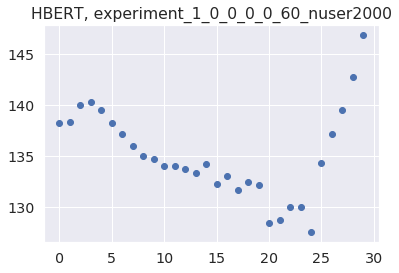

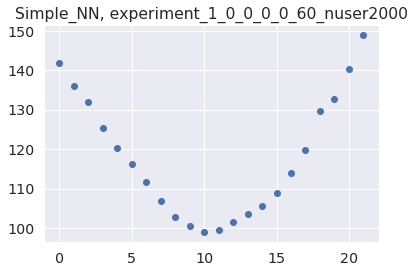

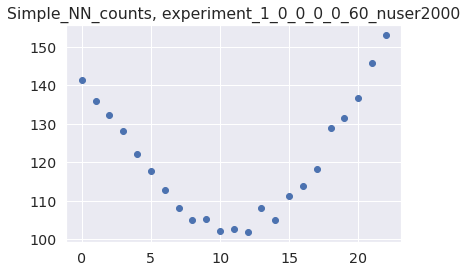

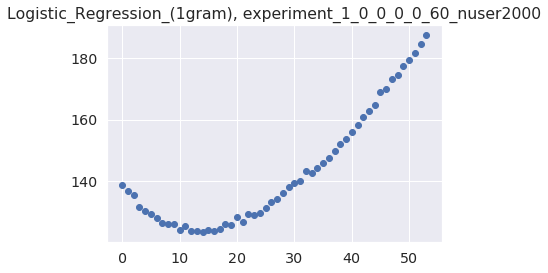

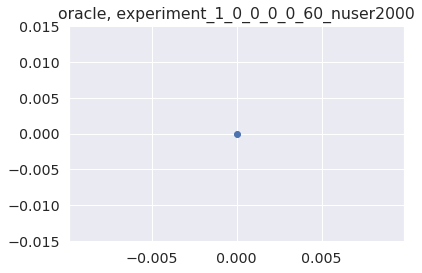

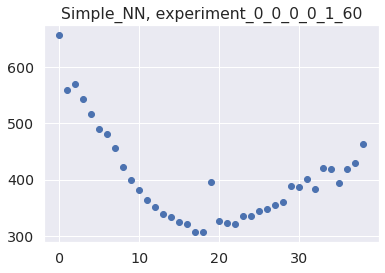

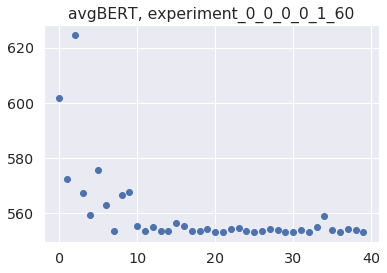

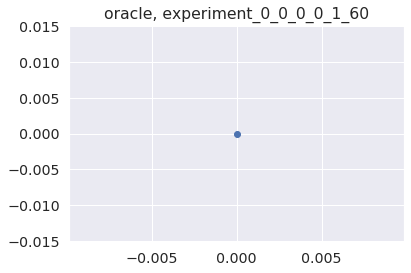

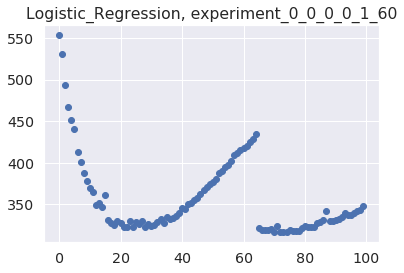

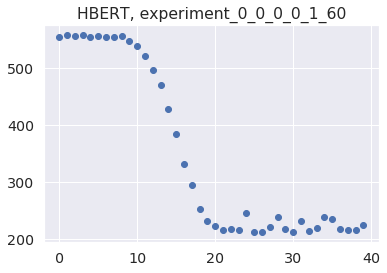

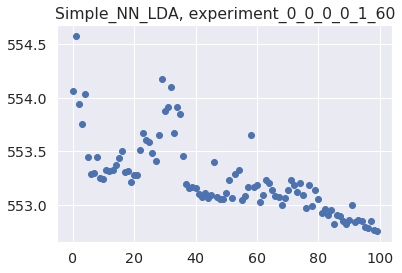

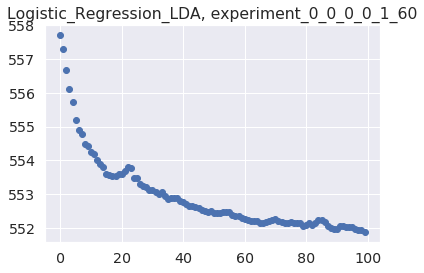

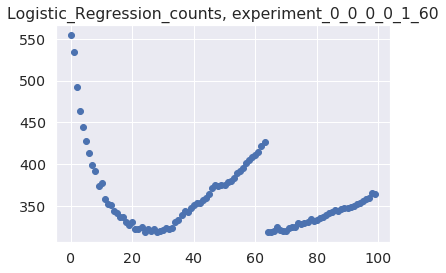

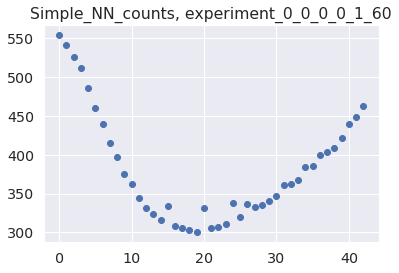

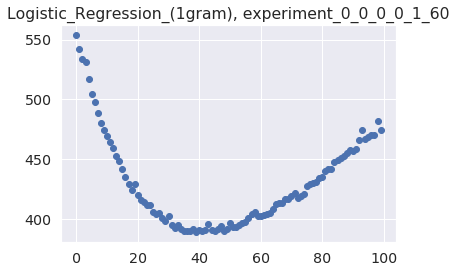

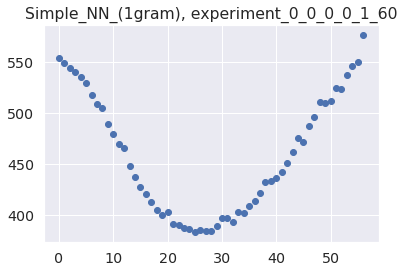

In [633]:
"""
This code block runs bootstrap experiments

Given the causal process specified above, it carried out many samples of user
treatment T and outcome Y on the test set, and runs causal analysis across these
stochastic samples for confidence intervals

"""

# list all names of models that were ru
model_names = ['oracle','Logistic_Regression_(1gram)',
              'Logistic_Regression','Simple_NN_(1gram)','Simple_NN', 'HBERT']

# this will hold the results of bootstrap experiments
results_dict = {}

# this will hold data frames for plotting
df_list = []

    
    
# iterate over the axes
for axis_experiment in list_of_axes:
    print('\n\n#######\nstarting: {}\n######## '.format(axis_experiment['name']))
    
    for experiment_ in axis_experiment['experiments']:
    
        print('running {}\n\n'.format(experiment_))
        
        exp_name = experiment_['file_path']
        
        results_dict[exp_name] = {}

        

        experiment_bootstraps = []

        show_curves = True

        # autofind model names
        model_names = [name.split('.')[0] for name in os.listdir(exp_name) if 'data' not in name and 'inds' not in name and '.pt' not in name]


        ## Get important arrays for statistics
        inds_dict = np.load(exp_name + '/inds_dict.npy').item()
        _, _, T, Y, classes = np.load(exp_name +'/data.npy')

        P_sample_classes = experiment_['P_sample_classes']
        P_true = P_sample_classes[0]*(1-classes) + P_sample_classes[1]*classes

        Pt_train = P_true[inds_dict['inds_train']]
        Pt_val = P_true[inds_dict['inds_val']]
        Pt_test = P_true[inds_dict['inds_test']]

        Tt_train = T[inds_dict['inds_train']]
        Tt_val = T[inds_dict['inds_val']]
        Tt_test = T[inds_dict['inds_test']]

        classes_test = classes[inds_dict['inds_test']]

        Y_sample_classes = experiment_['Y_sample_classes'] #[[0.9,0.1],[0.9,0.9]]

        #Y_sample_classes = [[0.9,0.1],[0.1,0.9]]


        experiment_['Pt_test'] = Pt_test

        experiment_['Pt_test'] = Pt_test

        Y_sample = np.zeros_like(Pt_test)
        for i in range(len(classes_test)):
            Y_sample[i] = 1.*(random.random() < Y_sample_classes[classes_test[i]][1*(Tt_test[i] == 0)])

        ATE_true = 0.5*((Y_sample_classes[0][0] - 
                         Y_sample_classes[0][1]) + 
                        (Y_sample_classes[1][0] - 
                        Y_sample_classes[1][1]))

        print('true ATE: {}'.format(ATE_true))
        #print('oracle ATE ipw: {}, strat: {}'.format(get_effect_iptw_ATE(Pt_test,Tt_test, Y_sample),
        #                                              get_effect_strat(Pt_test, Tt_test, Y_sample, K=5, value='ATE')[0]))

        bs_result = bootstrap_ATE(Pt_test, Tt_test, Y_sample, ATE_true, n_it=1000)
        bias_of_mean = abs(ATE_true - bs_result[0])
        print('ATE oracle bootstrap: {}'.format(bs_result))
        print('bias of mean: {}'.format(bias_of_mean))
        print('\n\n')
        #print('oracle ATE: {}'.format()) 
        stat_dict_oracle = {'P_test':Pt_test, 'learning_curve':[0], 'test_acc':.9,'test_CE':0}
        np.save('{}/oracle.npy'.format(exp_name), stat_dict_oracle)


        experiment_bootstraps += [{'oracle': bs_result[3]}]

        model_names = [name.split('.')[0] for name in os.listdir(exp_name) if 'data' not in name and 'inds' not in name and '.pt' not in name]

        results_dict_local = {}
        for i, model_name in enumerate(model_names):
            print('doing model {}'.format(model_name))


            #try:
            if (True):
                stat_dict = np.load('{}/{}.npy'.format(exp_name, model_name)).item()
                results_dict[exp_name][model_name] = {}


                results_dict_local[model_name] = {}
                results_dict_local[model_name]['name'] = model_name

                results_dict_local[model_name]['test_acc'] = []#test_acc
                results_dict_local[model_name]['test_CE'] = []#test_CE

                results_dict_local[model_name]['bias_strat'] = [] #abs(ATE_true - ATE_strat)
                results_dict_local[model_name]['bias_ipw'] = [] #abs(ATE_true - ATE_ipw)
                results_dict_local[model_name]['ATE_strat'] = [] #ATE_strat
                results_dict_local[model_name]['ATE_ipw'] = [] #ATE_ipw

                results_dict_local[model_name]['brier'] = [] #brier
                results_dict_local[model_name]['inv_brier'] = [] #inv_brier
                results_dict_local[model_name]['spearman'] = []
                results_dict_local[model_name]['mse_ipsw'] = []





                P_test = stat_dict['P_test']

                inds_treated = Tt_test == 1
                inds_control = Tt_test == 0


                Y_0 = np.mean((1 - Tt_test) * (Y_sample/(1 - P_test))   )

                Y_1 = np.mean( (Tt_test) * (Y_sample/(P_test))  ) 

                Yt_0 = np.mean( (1 - Tt_test) * (Y_sample/(1 - Pt_test)) )

                Yt_1 = np.mean( (Tt_test) *  (Y_sample/(Pt_test))  )

                b_1 = np.mean( (Tt_test) *  ((Y_sample/Pt_test) * (P_test - Pt_test)**2/(P_test**2))  )

                b_0 = np.mean( (1 - Tt_test) * ((Y_sample/(1 - Pt_test)) * (P_test - Pt_test)**2/((1 - P_test)**2))   )


                Y_estimates = (Y_0,Y_1)
                bound = (b_0,b_1)

                results_dict_local[model_name]['Y_estimates'] = Y_estimates
                results_dict_local[model_name]['Yt_estimates'] = (Yt_0,Yt_1)
                results_dict_local[model_name]['bound'] = bound

                #print(np.sum(((P_test >=0.5)*Tt_test) + (P_test <0.5)*(1-Tt_test))/len(P_test))

                plt.figure()
                plt.scatter(range(len(stat_dict['learning_curve'])),stat_dict['learning_curve'])
                plt.title('{}, {}'.format(model_name, exp_name))

                for _ in range(100):

                    inds_bs = np.random.choice(len(P_test), size=len(P_test), replace=True)

                    P_test_bs = P_test[inds_bs]
                    Pt_test_bs = Pt_test[inds_bs]
                    Tt_test_bs = Tt_test[inds_bs]
                    Y_sample_bs = Y_sample[inds_bs]

                    brier = ((P_test_bs - Pt_test_bs)**2).mean()
                    inv_brier = ((1./P_test_bs - 1./Pt_test_bs)**2).mean()

                    ATE_ipw, weights_ipsw = get_effect_iptw_ATE(P_test_bs, Tt_test_bs, Y_sample_bs, return_weights=True)
                    _, weights_ipw_oracle = get_effect_iptw_ATE(Pt_test_bs, Tt_test_bs, Y_sample_bs, return_weights=True)
                    mse_ipsw = (10**7)*np.mean( (weights_ipsw - weights_ipw_oracle)**2)


                    ATE_strat = get_effect_strat(P_test_bs, Tt_test_bs, Y_sample_bs, K=10, value='ATE')[0]


                    #bias_of_mean = abs(ATE_true - bs_out[0])


                    test_acc = np.sum(((P_test_bs >=0.5)*Tt_test_bs) + (P_test_bs <0.5)*(1-Tt_test_bs))/len(P_test_bs)
                    #np.sum(P_test_bs >=0.5*Tt_test_bs + P_test_bs <0.5*(1-Tt_test_bs))

                    results_dict_local[model_name]['test_acc'] = results_dict_local[model_name]['test_acc']+  [test_acc]#test_acc
                    #results_dict[exp_name][model_name]['test_CE'] = []#test_CE

                    results_dict_local[model_name]['bias_strat'] = results_dict_local[model_name]['bias_strat'] + [ATE_strat - ATE_true] #abs(ATE_true - ATE_strat)
                    results_dict_local[model_name]['bias_ipw'] = results_dict_local[model_name]['bias_ipw']+ [ATE_ipw - ATE_true] #abs(ATE_true - ATE_ipw)
                    results_dict_local[model_name]['ATE_strat'] = results_dict_local[model_name]['ATE_strat']+ [ATE_strat] #ATE_strat
                    results_dict_local[model_name]['ATE_ipw'] = results_dict_local[model_name]['ATE_ipw'] + [ATE_ipw] #ATE_ipw

                    results_dict_local[model_name]['brier'] = results_dict_local[model_name]['brier'] + [brier] #brier
                    results_dict_local[model_name]['inv_brier'] = results_dict_local[model_name]['inv_brier'] + [inv_brier] 
                    results_dict_local[model_name]['spearman'] = results_dict_local[model_name]['spearman'] + [stats.spearmanr(P_test, b=Pt_test, axis=0).correlation]
                    results_dict_local[model_name]['mse_ipsw'] = results_dict_local[model_name]['mse_ipsw'] + [mse_ipsw]
                    #experiment_bootstraps += [{model_name: bs_out[3]}]
            experiment_['results_dict'] = results_dict_local



#### 

In [695]:
# define metrics to plot

metrics = ['test_acc','bias_strat', 'bias_ipw', 'bias_ATE_mean','inv_brier'] 

# go from simple names to clear ones
beautify = {
    'test_acc': 'Treatment Accuracy',
    'bias_strat': 'Bias of ATE (Stratified)',
    'bias_ipw': 'Bias of ATE (IPTW)',
    'brier': 'Brier Score',
    'inv_brier': 'Inverse Brier Score',
    'spearman': 'Spearman correlation',
    
    0: 'Linguistic Complexity',
    1: 'Presence of Distractors',
    2: 'Post Order as a Feature',
    3: 'Intensity of Features',
    4: 'Complexity of Propensity',
    
    
    'HBERT':'SHERBERT',
     'Logistic_Regression_counts': 'Logistic Regression (1,2-grams, counted)',
     'avgBERT': 'Average Bert',
     'Logistic_Regression_(1gram)': 'Logistic Regression (1-grams)',
     'oracle': 'Oracle Propensity',
     'Simple_NN_counts': 'Simple NN (1,2-grams, counted)',
     'Simple_NN_(1gram)': 'Simple NN (1-grams)',
     'Simple_NN': 'Simple NN (1,2-grams)',
     'Logistic_Regression': 'Logistic Regression (1,2-grams)',
    'Simple_NN_LDA':'Simple NN (LDA features)',
    'Logistic_Regression_LDA': 'Logistic Regression (LDA features)',
    'mse_ipsw':'MSE of IPTW weights (*1e-7)',
    'bound': 'ATE bound'
    
}


sns.color_palette()

model_names_nice = [
    'Logistic Regression (1-grams)',
    'Simple NN (1-grams)',
    'Logistic Regression (1,2-grams)',
     'Simple NN (1,2-grams)',
      'Logistic Regression (1,2-grams, counted)',
     'Simple NN (1,2-grams, counted)',
    'Logistic Regression (LDA features)',
    'Simple NN (LDA features)',
    'SHERBERT',
 'Oracle Propensity',
 'Average Bert',
'Theoretical\nOptimum',
'Unadjusted\nEstimator']

color_map = {key:color for key, color in  zip( model_names_nice, sns.color_palette("Paired"))   }

symbols = ["v","^","<",">", "1","2","3","4","+","X","."]

marker_map = {key:marker for key, marker in  zip( model_names_nice, symbols)   }


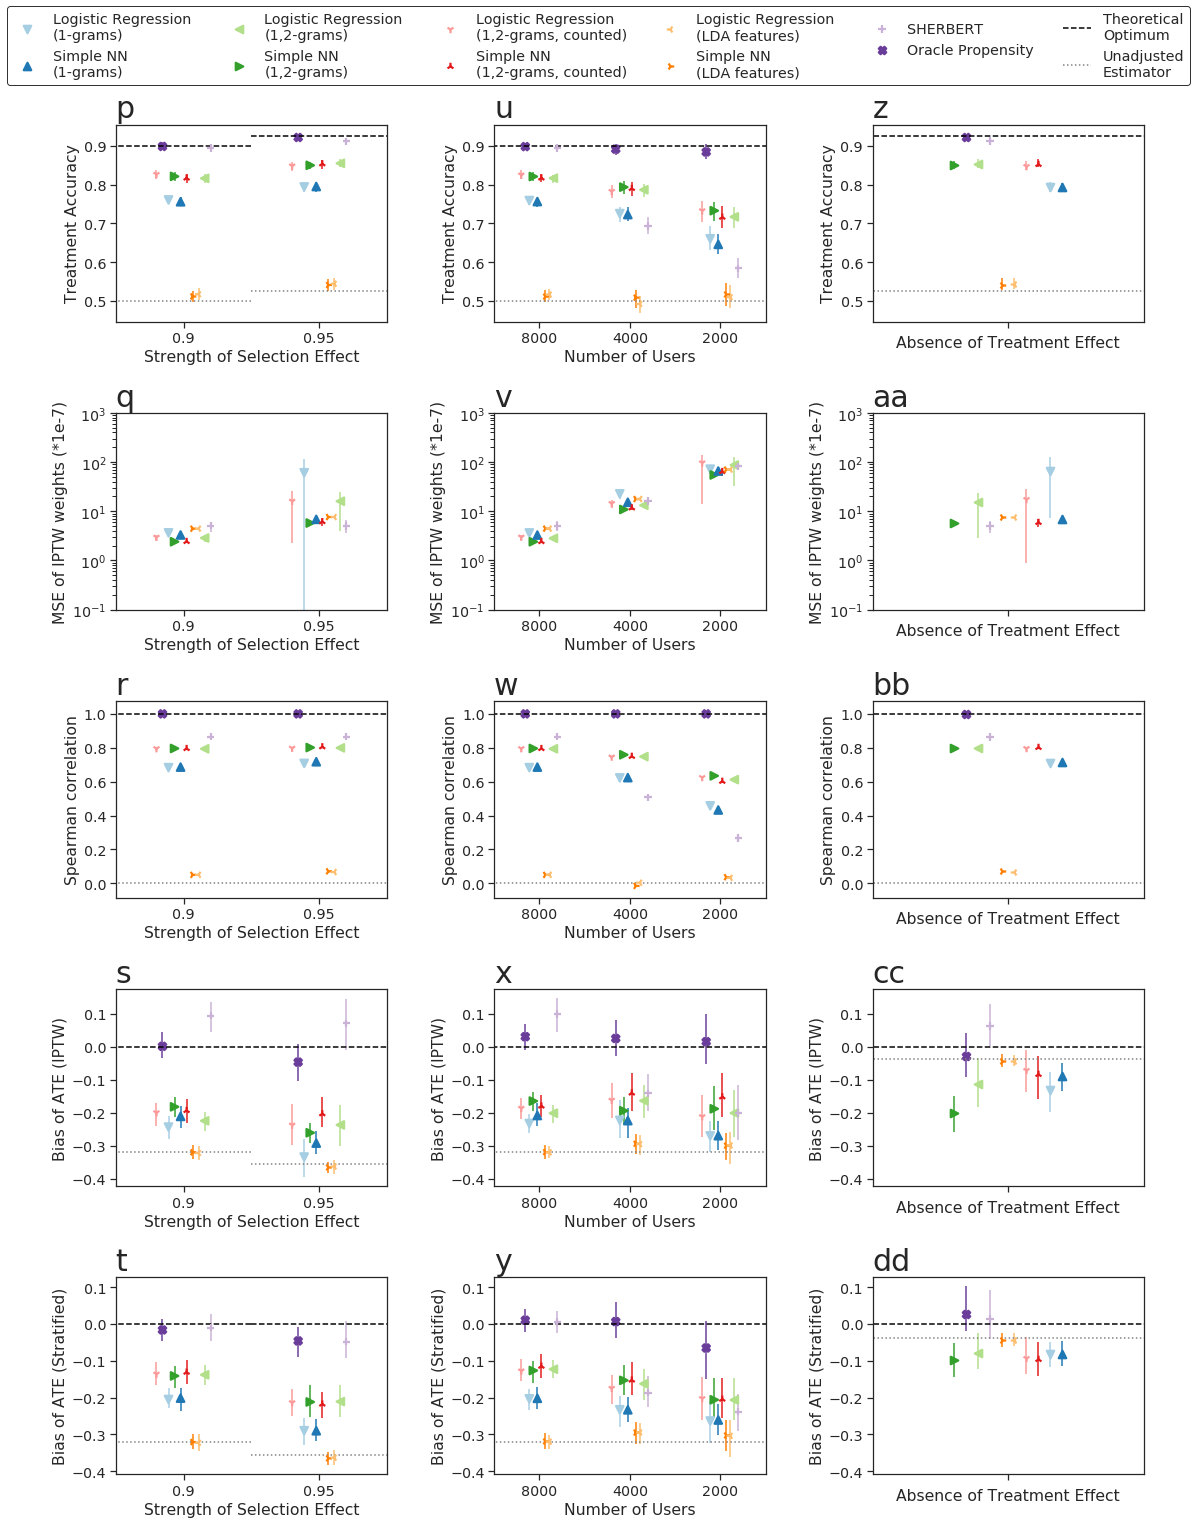

In [728]:
"""
This produces the plot from the original paper

To plot only some of the experiments, change the code block switching on fig
specifically, plots = range(x,y) should give the range of experiments to plot

"""

# choose which page of figures to plot...
fig = 2


sns.set_style("white")
sns.set_style("ticks")

f, axes = plt.subplots(nrows = 5, ncols=3, figsize = (16,20), sharey = 'row', sharex = 'col')
sns.set(font_scale=1.3)

if fig == 1:
    plots = range(0,3)
elif fig == 2:
    plots = range(3,6)
else:
    assert(False)

count = 0
for i_1, ax_ in list(enumerate(plots)):
    for i_0, target_key in enumerate(['test_acc',  'mse_ipsw','spearman','bias_ipw', 'bias_strat']):
        #filter_fun = lambda x: axis_check(x, ax_)

        #ax_names = filter(filter_fun, results_dict.keys())
        
        


        keys = []
        vals = []
        ax_vals = []
        bs_intervals = []
        
        symbol_list = []
        
        error_dict = {}

        axis_experiment = list_of_axes[ax_]
        for experiment_ in axis_experiment['experiments']:
        #for  ax_name in ax_names:
            ax_val = experiment_['axis_value']# int(ax_name.split('_')[ax_ + 1])    

            #print(ax_name)

            results_dict = experiment_['results_dict']
            model_names = results_dict.keys()
            model_names = [n for n in model_names if 'avg' not in n]
            for model_name in model_names:


                key = model_name 

                bs_sample = results_dict[model_name][target_key]

                bs_mean = sum(bs_sample)/len(bs_sample)
                lb = bs_mean - np.percentile(bs_sample,2.5)
                ub = np.percentile(bs_sample,97.5) - bs_mean

                vals = vals + [bs_mean]
                keys = keys + [beautify[key]]

                ax_vals = ax_vals + [ax_val]
                bs_intervals = bs_intervals + [(ub,lb)]
                
                error_dict[bs_mean] = (ub,lb)
                
                symbol_list += [marker_map[  beautify[key]]]

                if 'Regression_(1gram)' in key and 'mse' in target_key:
                    #print('here')
                    #print(bs_sample)
                    #print(bs_mean)
                    pass
                #print(len(vals))


        d = {'keys': keys, beautify[target_key]:vals, axis_experiment['name'] :ax_vals, 'intervals':bs_intervals, 'symbols':symbol_list}
        df = pd.DataFrame(data=d)
        #df.sort_values(by=['keys'])

        
        marker_list = list(df['symbols'])
        #print(target_key)
        #print(df)
        #plt.figure(figsize=(8,8))
        

        if 'MSE' in beautify[target_key]:
            axes[i_0, i_1].set_ylim((10**-1, 10**3))
            axes[i_0, i_1].set( yscale="log")

            
        ax = sns.pointplot(data=df,x =axis_experiment['name'],y = beautify[target_key], hue='keys', palette=color_map, dodge=.4, join=False, ci = 'sd' , ax=axes[i_0, i_1], markers = marker_list, scale = 1.1 )
        

        

        


        #plt.title('{} for {}'.format(beautify[target_key], beautify[ax_]), size = 15)
        




        ##
        # Finally, plot custom error bars
        ##


        # get error bar values
        intervals = list(df['intervals'])
        intervals_array = np.array(intervals).transpose()


        # Find the x,y coordinates for each point
        x_coords = []
        y_coords = []
        colors = []
        
        intervals_list = []
        for point_pair in ax.collections:
            for ((x, y), color) in zip(point_pair.get_offsets(), point_pair.get_facecolors()):
                x_coords.append(x)
                y_coords.append(y)
                intervals_list += [error_dict[y]]
                colors.append(color)
        intervals_array = np.array(intervals_list).transpose()

        # Calculate the type of error to plot as the error bars
        # Make sure the order is the same as the points were looped over
        #errors = tips.groupby(['smoker', 'sex']).std()['tip']
        #colors = ['steelblue']*2 + ['coral']*2
        ax.errorbar(x_coords, y_coords, yerr=intervals_array,
            ecolor=colors, fmt=' ', zorder=-1)
        
        #ax.legend(loc = (7,7))
        
        #plt.legend(loc=(100,100))
        
        
        if target_key in axis_experiment['optimal']:
            
            if type(axis_experiment['optimal'][target_key]) is tuple:
                
                y_val = axis_experiment['optimal'][target_key][0]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [-100,0.5]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='black', linestyle='--')
                ax.set_xlim(xlim)
                
                y_val = axis_experiment['optimal'][target_key][1]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [0.5,100]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='black', linestyle='--', label = 'Theoretical\nOptimum')
                ax.set_xlim(xlim)
                
            else:
            
                y_val = axis_experiment['optimal'][target_key]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [-100,100]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='black', linestyle='--', label = 'Theoretical\nOptimum')
                ax.set_xlim(xlim)

            
        if target_key in axis_experiment['unadjusted']:
            if type(axis_experiment['unadjusted'][target_key]) is tuple:
                y_val = axis_experiment['unadjusted'][target_key][0]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [-100,0.5]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='grey', linestyle=':')
                ax.set_xlim(xlim)
                
                y_val = axis_experiment['unadjusted'][target_key][1]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [0.5,100]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='grey', linestyle=':',label = 'Unadjusted\nEstimator')
                ax.set_xlim(xlim)
                
            else:
            
                y_val = axis_experiment['unadjusted'][target_key]
                xlim = ax.get_xlim()
                ax.set_xlim(xlim)

                x = [-100,100]
                y=[y_val,y_val]
                #ax = sns.lineplot(x,y)
                ax.plot(x,y, color='grey', linestyle=':',label = 'Unadjusted\nEstimator')
                ax.set_xlim(xlim)
            
        '''
        if 'Bias' in beautify[target_key]:     
            print('BIAS!!!')
            xlim = ax.get_xlim()
            ax.set_xlim(xlim)
            print(x)
            print((i_1,i_0))
            x = [-10,10]
            y=[0,0]
            #ax = sns.lineplot(x,y)
            ax.plot(x,y, color='lightgrey', linestyle='--')
            ax.set_xlim(xlim)
            
        if 'Accuracy' in beautify[target_key]:
            print('BIAS!!!')
            xlim = ax.get_xlim()
            ax.set_xlim(xlim)

            x = [-10,10]
            y=[0.9,0.9]
            #ax = sns.lineplot(x,y)
            ax.plot(x,y, color='lightgrey', linestyle='--')
            ax.set_xlim(xlim)
            
            x = [-10,10]
            y=[0.5,0.5]
            #ax = sns.lineplot(x,y)
            ax.plot(x,y, color='lightgrey', linestyle=':')
            ax.set_xlim(xlim)
        '''
            
        if 'mse' in beautify[target_key]:
            #ax.set_ylim((-5, 40))
            ax.set( yscale="log")
            #ax.ticklabel_format(axis='y', style='sci')
        
        xlim = axes[i_0, i_1].get_xlim()
        ylim = axes[i_0, i_1].get_xlim()
        
        pos = ax.get_position()

        
        import string
        letters = [s for s in string.ascii_lowercase] + ['aa', 'bb','cc','dd','ee','ff']
        letter = letters[count]
        count += 1
        
        #f.text(pos.x0,pos.y1,letter, size=30)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        
        #ax._xticks(range(len(axis_experiment['labels']) ), axis_experiment['labels'])
        ax.set_xticklabels(axis_experiment['labels'])
            

        handles, labels = ax.get_legend_handles_labels()
        inds = [labels.index(n) for n in [name for name in model_names_nice if name in labels]]

        handles_0 = [handles[i] for i in inds]
        labels_0 = [labels[i] for i in inds]
        #ax.legend(handles_0, labels_0, loc = (-0.25,1.05), ncol=4)
        labels_1 = []
        
        for label in labels_0:
            if '(' in label:
                labels_1 += [label.split('(')[0] + '\n(' +label.split('(')[1] ]
            else:
                labels_1 += [label]
        

        #if i_0 == 0:
        #ax.set_xlabel(beautify[ax_], size = 15 )
        #if i_1 == 0:
        #ax.set_ylabel(beautify[target_key], size = 15 )
            
            
# make layout tight
plt.tight_layout()          
## add letters
for i_1, ax_ in list(enumerate(plots)):
    for i_0, target_key in enumerate(['test_acc',  'mse_ipsw','spearman','bias_ipw', 'bias_strat']):
        ax=axes[i_0, i_1]
        
        
        ax.legend(handles_0, labels_1, facecolor= 'white',edgecolor='black',loc = (-.4,1.2), ncol=6)

        
        if i_0 != 0 or i_1 !=0:
            

            ax.get_legend().remove()
            
        
        
        pos = ax.get_position()
        
        import string
        letters = [s for s in string.ascii_lowercase] + ['aa', 'bb','cc','dd','ee','ff']
        
        count = (fig - 1)*15 + i_0 + 5*i_1
        letter = letters[count]
        count += 1
        f.text(pos.x0,pos.y1 + 0.005,letter, size=30)
        


from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('synth_{}.pdf'.format(fig)) as pdf:
    pdf.savefig(f, bbox_inches = 'tight')
    
#plt.tight_layout()
f.savefig('synth_{}.png'.format(fig),format='png', bbox_inches = 'tight', dpi=100)

